In [6]:

%load_ext autoreload
%autoreload 2
from trainer import LitModel
import torch 
from shared_modules.data_module import DataModule
from shared_modules.utils import load_config
from shared_modules.post_transforms import get_post_transforms
from monai.transforms import AsDiscrete
from tqdm import tqdm
from monai.metrics import DiceMetric
from monai.data import decollate_batch

# Settings:
SAVE_PREDS=True
SAVE_PROB_MAPS=True
dataset="p158" 
label_key = "zones" if dataset == "p158" else "prostate"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
config = load_config("config.yaml")
gpu = 0
config.gpus = [gpu]
config.cache_rate = 1.0
config.data.json_list = f"../../json_datalists/{dataset}/all_samples.json"
config.transforms.label_keys=[label_key]



checkpoint_path = "trained_models/cspca_algos_dev/UMambaBot_px_[prostate_seg]/UMambaBot/5oh6oody/epoch=359-dsc_prostate=0.9143.ckpt"
model = LitModel.load_from_checkpoint(checkpoint_path, config=config)

# disable randomness, dropout, etc...
model = model.eval()
model.to(gpu)

LitModel(
  (model): UMambaBot(
    (encoder): UNetResEncoder(
      (stem): Sequential(
        (0): BasicResBlock(
          (conv1): Conv3d(3, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
          (norm1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (act1): LeakyReLU(negative_slope=0.01, inplace=True)
          (conv2): Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
          (norm2): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (act2): LeakyReLU(negative_slope=0.01, inplace=True)
          (conv3): Conv3d(3, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        )
        (1): BasicBlockD(
          (conv1): ConvDropoutNormReLU(
            (conv): Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
            (norm): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (no

In [8]:

dm = DataModule(
    config=config,
)

dm.setup("test")
dl = dm.test_dataloader()

Loading dataset:   0%|          | 0/158 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 158/158 [00:42<00:00,  3.71it/s]


In [9]:
pred_post_transforms = get_post_transforms(key="pred", 
                    orig_key=label_key,
                    orig_transforms=dm.transforms["test"],
                    out_dir=f"output/{dataset}/preds/",
                    keep_n_largest_components=1,
                    output_postfix="pred",
                    save_mask=True)

prob_map_post_transforms = get_post_transforms(key="prob", 
                    orig_key=label_key,
                    orig_transforms=dm.transforms["test"],
                    out_dir=f"output/{dataset}/prob/",
                    keep_n_largest_components=0,
                    output_postfix="prob",
                    output_dtype="float32",
                    save_mask=True)

In [10]:
dsc_fn = DiceMetric(include_background=False, reduction="mean")

for batch in tqdm(dl):
    with torch.no_grad():
        logits = model.inferer(batch["image"].to(gpu))
        
    batch["pred"] = AsDiscrete(argmax=True)(logits[0])[None]
    batch["prob"] = torch.softmax(logits, dim=1)[0:1,1:2,...]
    dsc_fn(y_pred=batch["pred"], y=batch[label_key].to(gpu))
    
    if dataset == "p158":
        filename = batch["pca"][0].split("/")[-2]
        batch[label_key].meta["filename_or_obj"] = filename
    
    if SAVE_PREDS:
        [pred_post_transforms(i) for i in decollate_batch(batch)]
    if SAVE_PROB_MAPS:
        [prob_map_post_transforms(i) for i in decollate_batch(batch)]
            
        
        
metrics = dsc_fn.aggregate("none")

  0%|          | 0/158 [00:00<?, ?it/s]

2024-07-23 14:34:06,460 INFO image_writer.py:197 - writing: output/p158/preds/085_pred.nii.gz
2024-07-23 14:34:06,485 INFO image_writer.py:197 - writing: output/p158/prob/085_prob.nii.gz


  1%|          | 1/158 [00:00<00:44,  3.51it/s]

2024-07-23 14:34:06,725 INFO image_writer.py:197 - writing: output/p158/preds/016_pred.nii.gz
2024-07-23 14:34:06,744 INFO image_writer.py:197 - writing: output/p158/prob/016_prob.nii.gz


  1%|▏         | 2/158 [00:00<00:42,  3.67it/s]

2024-07-23 14:34:06,985 INFO image_writer.py:197 - writing: output/p158/preds/095_pred.nii.gz
2024-07-23 14:34:07,008 INFO image_writer.py:197 - writing: output/p158/prob/095_prob.nii.gz


  2%|▏         | 3/158 [00:00<00:41,  3.74it/s]

2024-07-23 14:34:07,250 INFO image_writer.py:197 - writing: output/p158/preds/120_pred.nii.gz
2024-07-23 14:34:07,273 INFO image_writer.py:197 - writing: output/p158/prob/120_prob.nii.gz


  3%|▎         | 4/158 [00:01<00:41,  3.74it/s]

2024-07-23 14:34:07,512 INFO image_writer.py:197 - writing: output/p158/preds/087_pred.nii.gz
2024-07-23 14:34:07,539 INFO image_writer.py:197 - writing: output/p158/prob/087_prob.nii.gz


  3%|▎         | 5/158 [00:01<00:40,  3.76it/s]

2024-07-23 14:34:07,834 INFO image_writer.py:197 - writing: output/p158/preds/139_pred.nii.gz
2024-07-23 14:34:07,886 INFO image_writer.py:197 - writing: output/p158/prob/139_prob.nii.gz


  4%|▍         | 6/158 [00:01<00:48,  3.15it/s]

2024-07-23 14:34:08,273 INFO image_writer.py:197 - writing: output/p158/preds/158_pred.nii.gz
2024-07-23 14:34:08,323 INFO image_writer.py:197 - writing: output/p158/prob/158_prob.nii.gz


  4%|▍         | 7/158 [00:02<00:54,  2.75it/s]

2024-07-23 14:34:08,719 INFO image_writer.py:197 - writing: output/p158/preds/055_pred.nii.gz
2024-07-23 14:34:08,767 INFO image_writer.py:197 - writing: output/p158/prob/055_prob.nii.gz


  5%|▌         | 8/158 [00:02<00:57,  2.61it/s]

2024-07-23 14:34:09,146 INFO image_writer.py:197 - writing: output/p158/preds/140_pred.nii.gz
2024-07-23 14:34:09,195 INFO image_writer.py:197 - writing: output/p158/prob/140_prob.nii.gz


  6%|▌         | 9/158 [00:03<00:59,  2.52it/s]

2024-07-23 14:34:09,507 INFO image_writer.py:197 - writing: output/p158/preds/042_pred.nii.gz
2024-07-23 14:34:09,527 INFO image_writer.py:197 - writing: output/p158/prob/042_prob.nii.gz


  6%|▋         | 10/158 [00:03<00:52,  2.83it/s]

2024-07-23 14:34:09,775 INFO image_writer.py:197 - writing: output/p158/preds/100_pred.nii.gz
2024-07-23 14:34:09,799 INFO image_writer.py:197 - writing: output/p158/prob/100_prob.nii.gz


  7%|▋         | 11/158 [00:03<00:48,  3.04it/s]

2024-07-23 14:34:10,094 INFO image_writer.py:197 - writing: output/p158/preds/108_pred.nii.gz
2024-07-23 14:34:10,139 INFO image_writer.py:197 - writing: output/p158/prob/108_prob.nii.gz


  8%|▊         | 12/158 [00:04<00:51,  2.81it/s]

2024-07-23 14:34:10,454 INFO image_writer.py:197 - writing: output/p158/preds/136_pred.nii.gz
2024-07-23 14:34:10,476 INFO image_writer.py:197 - writing: output/p158/prob/136_prob.nii.gz


  8%|▊         | 13/158 [00:04<00:47,  3.05it/s]

2024-07-23 14:34:10,715 INFO image_writer.py:197 - writing: output/p158/preds/156_pred.nii.gz
2024-07-23 14:34:10,735 INFO image_writer.py:197 - writing: output/p158/prob/156_prob.nii.gz


  9%|▉         | 14/158 [00:04<00:43,  3.28it/s]

2024-07-23 14:34:10,972 INFO image_writer.py:197 - writing: output/p158/preds/117_pred.nii.gz
2024-07-23 14:34:10,994 INFO image_writer.py:197 - writing: output/p158/prob/117_prob.nii.gz


  9%|▉         | 15/158 [00:04<00:41,  3.42it/s]

2024-07-23 14:34:11,230 INFO image_writer.py:197 - writing: output/p158/preds/078_pred.nii.gz
2024-07-23 14:34:11,255 INFO image_writer.py:197 - writing: output/p158/prob/078_prob.nii.gz


 10%|█         | 16/158 [00:05<00:40,  3.54it/s]

2024-07-23 14:34:11,510 INFO image_writer.py:197 - writing: output/p158/preds/024_pred.nii.gz
2024-07-23 14:34:11,534 INFO image_writer.py:197 - writing: output/p158/prob/024_prob.nii.gz


 11%|█         | 17/158 [00:05<00:39,  3.54it/s]

2024-07-23 14:34:11,775 INFO image_writer.py:197 - writing: output/p158/preds/082_pred.nii.gz
2024-07-23 14:34:11,800 INFO image_writer.py:197 - writing: output/p158/prob/082_prob.nii.gz


 11%|█▏        | 18/158 [00:05<00:38,  3.61it/s]

2024-07-23 14:34:12,131 INFO image_writer.py:197 - writing: output/p158/preds/048_pred.nii.gz
2024-07-23 14:34:12,188 INFO image_writer.py:197 - writing: output/p158/prob/048_prob.nii.gz


 12%|█▏        | 19/158 [00:06<00:46,  2.96it/s]

2024-07-23 14:34:12,518 INFO image_writer.py:197 - writing: output/p158/preds/013_pred.nii.gz
2024-07-23 14:34:12,536 INFO image_writer.py:197 - writing: output/p158/prob/013_prob.nii.gz


 13%|█▎        | 20/158 [00:06<00:42,  3.24it/s]

2024-07-23 14:34:12,768 INFO image_writer.py:197 - writing: output/p158/preds/036_pred.nii.gz
2024-07-23 14:34:12,789 INFO image_writer.py:197 - writing: output/p158/prob/036_prob.nii.gz


 13%|█▎        | 21/158 [00:06<00:40,  3.39it/s]

2024-07-23 14:34:13,021 INFO image_writer.py:197 - writing: output/p158/preds/080_pred.nii.gz
2024-07-23 14:34:13,043 INFO image_writer.py:197 - writing: output/p158/prob/080_prob.nii.gz


 14%|█▍        | 22/158 [00:06<00:38,  3.52it/s]

2024-07-23 14:34:13,276 INFO image_writer.py:197 - writing: output/p158/preds/010_pred.nii.gz
2024-07-23 14:34:13,295 INFO image_writer.py:197 - writing: output/p158/prob/010_prob.nii.gz


 15%|█▍        | 23/158 [00:07<00:36,  3.69it/s]

2024-07-23 14:34:13,527 INFO image_writer.py:197 - writing: output/p158/preds/128_pred.nii.gz
2024-07-23 14:34:13,549 INFO image_writer.py:197 - writing: output/p158/prob/128_prob.nii.gz


 15%|█▌        | 24/158 [00:07<00:35,  3.73it/s]

2024-07-23 14:34:13,825 INFO image_writer.py:197 - writing: output/p158/preds/153_pred.nii.gz
2024-07-23 14:34:13,882 INFO image_writer.py:197 - writing: output/p158/prob/153_prob.nii.gz


 16%|█▌        | 25/158 [00:07<00:42,  3.15it/s]

2024-07-23 14:34:14,254 INFO image_writer.py:197 - writing: output/p158/preds/063_pred.nii.gz
2024-07-23 14:34:14,277 INFO image_writer.py:197 - writing: output/p158/prob/063_prob.nii.gz


 16%|█▋        | 26/158 [00:08<00:41,  3.19it/s]

2024-07-23 14:34:14,530 INFO image_writer.py:197 - writing: output/p158/preds/079_pred.nii.gz
2024-07-23 14:34:14,552 INFO image_writer.py:197 - writing: output/p158/prob/079_prob.nii.gz


 17%|█▋        | 27/158 [00:08<00:39,  3.33it/s]

2024-07-23 14:34:14,791 INFO image_writer.py:197 - writing: output/p158/preds/154_pred.nii.gz
2024-07-23 14:34:14,815 INFO image_writer.py:197 - writing: output/p158/prob/154_prob.nii.gz


 18%|█▊        | 28/158 [00:08<00:37,  3.45it/s]

2024-07-23 14:34:15,108 INFO image_writer.py:197 - writing: output/p158/preds/054_pred.nii.gz
2024-07-23 14:34:15,171 INFO image_writer.py:197 - writing: output/p158/prob/054_prob.nii.gz


 18%|█▊        | 29/158 [00:09<00:43,  2.97it/s]

2024-07-23 14:34:15,506 INFO image_writer.py:197 - writing: output/p158/preds/035_pred.nii.gz
2024-07-23 14:34:15,528 INFO image_writer.py:197 - writing: output/p158/prob/035_prob.nii.gz


 19%|█▉        | 30/158 [00:09<00:40,  3.18it/s]

2024-07-23 14:34:15,778 INFO image_writer.py:197 - writing: output/p158/preds/147_pred.nii.gz
2024-07-23 14:34:15,801 INFO image_writer.py:197 - writing: output/p158/prob/147_prob.nii.gz


 20%|█▉        | 31/158 [00:09<00:38,  3.30it/s]

2024-07-23 14:34:16,055 INFO image_writer.py:197 - writing: output/p158/preds/051_pred.nii.gz
2024-07-23 14:34:16,077 INFO image_writer.py:197 - writing: output/p158/prob/051_prob.nii.gz


 20%|██        | 32/158 [00:09<00:37,  3.40it/s]

2024-07-23 14:34:16,374 INFO image_writer.py:197 - writing: output/p158/preds/044_pred.nii.gz
2024-07-23 14:34:16,427 INFO image_writer.py:197 - writing: output/p158/prob/044_prob.nii.gz


 21%|██        | 33/158 [00:10<00:41,  2.99it/s]

2024-07-23 14:34:16,756 INFO image_writer.py:197 - writing: output/p158/preds/029_pred.nii.gz
2024-07-23 14:34:16,780 INFO image_writer.py:197 - writing: output/p158/prob/029_prob.nii.gz


 22%|██▏       | 34/158 [00:10<00:39,  3.13it/s]

2024-07-23 14:34:17,027 INFO image_writer.py:197 - writing: output/p158/preds/030_pred.nii.gz
2024-07-23 14:34:17,049 INFO image_writer.py:197 - writing: output/p158/prob/030_prob.nii.gz


 22%|██▏       | 35/158 [00:10<00:37,  3.31it/s]

2024-07-23 14:34:17,296 INFO image_writer.py:197 - writing: output/p158/preds/148_pred.nii.gz
2024-07-23 14:34:17,318 INFO image_writer.py:197 - writing: output/p158/prob/148_prob.nii.gz


 23%|██▎       | 36/158 [00:11<00:35,  3.41it/s]

2024-07-23 14:34:17,565 INFO image_writer.py:197 - writing: output/p158/preds/028_pred.nii.gz
2024-07-23 14:34:17,589 INFO image_writer.py:197 - writing: output/p158/prob/028_prob.nii.gz


 23%|██▎       | 37/158 [00:11<00:34,  3.47it/s]

2024-07-23 14:34:17,843 INFO image_writer.py:197 - writing: output/p158/preds/058_pred.nii.gz
2024-07-23 14:34:17,865 INFO image_writer.py:197 - writing: output/p158/prob/058_prob.nii.gz


 24%|██▍       | 38/158 [00:11<00:33,  3.55it/s]

2024-07-23 14:34:18,103 INFO image_writer.py:197 - writing: output/p158/preds/116_pred.nii.gz
2024-07-23 14:34:18,128 INFO image_writer.py:197 - writing: output/p158/prob/116_prob.nii.gz


 25%|██▍       | 39/158 [00:11<00:33,  3.59it/s]

2024-07-23 14:34:18,376 INFO image_writer.py:197 - writing: output/p158/preds/118_pred.nii.gz
2024-07-23 14:34:18,400 INFO image_writer.py:197 - writing: output/p158/prob/118_prob.nii.gz


 25%|██▌       | 40/158 [00:12<00:32,  3.61it/s]

2024-07-23 14:34:18,662 INFO image_writer.py:197 - writing: output/p158/preds/021_pred.nii.gz
2024-07-23 14:34:18,685 INFO image_writer.py:197 - writing: output/p158/prob/021_prob.nii.gz


 26%|██▌       | 41/158 [00:12<00:32,  3.63it/s]

2024-07-23 14:34:18,927 INFO image_writer.py:197 - writing: output/p158/preds/039_pred.nii.gz
2024-07-23 14:34:18,950 INFO image_writer.py:197 - writing: output/p158/prob/039_prob.nii.gz


 27%|██▋       | 42/158 [00:12<00:31,  3.65it/s]

2024-07-23 14:34:19,223 INFO image_writer.py:197 - writing: output/p158/preds/103_pred.nii.gz
2024-07-23 14:34:19,276 INFO image_writer.py:197 - writing: output/p158/prob/103_prob.nii.gz


 27%|██▋       | 43/158 [00:13<00:36,  3.17it/s]

2024-07-23 14:34:19,616 INFO image_writer.py:197 - writing: output/p158/preds/062_pred.nii.gz
2024-07-23 14:34:19,640 INFO image_writer.py:197 - writing: output/p158/prob/062_prob.nii.gz


 28%|██▊       | 44/158 [00:13<00:34,  3.30it/s]

2024-07-23 14:34:19,915 INFO image_writer.py:197 - writing: output/p158/preds/133_pred.nii.gz
2024-07-23 14:34:19,938 INFO image_writer.py:197 - writing: output/p158/prob/133_prob.nii.gz


 28%|██▊       | 45/158 [00:13<00:34,  3.32it/s]

2024-07-23 14:34:20,203 INFO image_writer.py:197 - writing: output/p158/preds/094_pred.nii.gz
2024-07-23 14:34:20,227 INFO image_writer.py:197 - writing: output/p158/prob/094_prob.nii.gz


 29%|██▉       | 46/158 [00:14<00:33,  3.37it/s]

2024-07-23 14:34:20,462 INFO image_writer.py:197 - writing: output/p158/preds/091_pred.nii.gz
2024-07-23 14:34:20,486 INFO image_writer.py:197 - writing: output/p158/prob/091_prob.nii.gz


 30%|██▉       | 47/158 [00:14<00:31,  3.48it/s]

2024-07-23 14:34:20,724 INFO image_writer.py:197 - writing: output/p158/preds/032_pred.nii.gz
2024-07-23 14:34:20,746 INFO image_writer.py:197 - writing: output/p158/prob/032_prob.nii.gz


 30%|███       | 48/158 [00:14<00:30,  3.58it/s]

2024-07-23 14:34:21,040 INFO image_writer.py:197 - writing: output/p158/preds/149_pred.nii.gz
2024-07-23 14:34:21,106 INFO image_writer.py:197 - writing: output/p158/prob/149_prob.nii.gz


 31%|███       | 49/158 [00:15<00:36,  2.97it/s]

2024-07-23 14:34:21,531 INFO image_writer.py:197 - writing: output/p158/preds/060_pred.nii.gz
2024-07-23 14:34:21,594 INFO image_writer.py:197 - writing: output/p158/prob/060_prob.nii.gz


 32%|███▏      | 50/158 [00:15<00:40,  2.66it/s]

2024-07-23 14:34:21,937 INFO image_writer.py:197 - writing: output/p158/preds/027_pred.nii.gz
2024-07-23 14:34:21,959 INFO image_writer.py:197 - writing: output/p158/prob/027_prob.nii.gz


 32%|███▏      | 51/158 [00:15<00:36,  2.90it/s]

2024-07-23 14:34:22,200 INFO image_writer.py:197 - writing: output/p158/preds/005_pred.nii.gz
2024-07-23 14:34:22,221 INFO image_writer.py:197 - writing: output/p158/prob/005_prob.nii.gz


 33%|███▎      | 52/158 [00:16<00:33,  3.12it/s]

2024-07-23 14:34:22,493 INFO image_writer.py:197 - writing: output/p158/preds/098_pred.nii.gz
2024-07-23 14:34:22,542 INFO image_writer.py:197 - writing: output/p158/prob/098_prob.nii.gz


 34%|███▎      | 53/158 [00:16<00:35,  2.95it/s]

2024-07-23 14:34:22,849 INFO image_writer.py:197 - writing: output/p158/preds/067_pred.nii.gz
2024-07-23 14:34:22,874 INFO image_writer.py:197 - writing: output/p158/prob/067_prob.nii.gz


 34%|███▍      | 54/158 [00:16<00:33,  3.14it/s]

2024-07-23 14:34:23,118 INFO image_writer.py:197 - writing: output/p158/preds/146_pred.nii.gz
2024-07-23 14:34:23,144 INFO image_writer.py:197 - writing: output/p158/prob/146_prob.nii.gz


 35%|███▍      | 55/158 [00:16<00:31,  3.30it/s]

2024-07-23 14:34:23,385 INFO image_writer.py:197 - writing: output/p158/preds/151_pred.nii.gz
2024-07-23 14:34:23,409 INFO image_writer.py:197 - writing: output/p158/prob/151_prob.nii.gz


 35%|███▌      | 56/158 [00:17<00:29,  3.43it/s]

2024-07-23 14:34:23,647 INFO image_writer.py:197 - writing: output/p158/preds/135_pred.nii.gz
2024-07-23 14:34:23,671 INFO image_writer.py:197 - writing: output/p158/prob/135_prob.nii.gz


 36%|███▌      | 57/158 [00:17<00:28,  3.52it/s]

2024-07-23 14:34:23,922 INFO image_writer.py:197 - writing: output/p158/preds/052_pred.nii.gz
2024-07-23 14:34:23,945 INFO image_writer.py:197 - writing: output/p158/prob/052_prob.nii.gz


 37%|███▋      | 58/158 [00:17<00:28,  3.55it/s]

2024-07-23 14:34:24,243 INFO image_writer.py:197 - writing: output/p158/preds/142_pred.nii.gz
2024-07-23 14:34:24,290 INFO image_writer.py:197 - writing: output/p158/prob/142_prob.nii.gz


 37%|███▋      | 59/158 [00:18<00:31,  3.14it/s]

2024-07-23 14:34:24,642 INFO image_writer.py:197 - writing: output/p158/preds/053_pred.nii.gz
2024-07-23 14:34:24,691 INFO image_writer.py:197 - writing: output/p158/prob/053_prob.nii.gz


 38%|███▊      | 60/158 [00:18<00:33,  2.89it/s]

2024-07-23 14:34:25,014 INFO image_writer.py:197 - writing: output/p158/preds/069_pred.nii.gz
2024-07-23 14:34:25,037 INFO image_writer.py:197 - writing: output/p158/prob/069_prob.nii.gz


 39%|███▊      | 61/158 [00:18<00:31,  3.10it/s]

2024-07-23 14:34:25,268 INFO image_writer.py:197 - writing: output/p158/preds/007_pred.nii.gz
2024-07-23 14:34:25,289 INFO image_writer.py:197 - writing: output/p158/prob/007_prob.nii.gz


 39%|███▉      | 62/158 [00:19<00:29,  3.31it/s]

2024-07-23 14:34:25,553 INFO image_writer.py:197 - writing: output/p158/preds/023_pred.nii.gz
2024-07-23 14:34:25,576 INFO image_writer.py:197 - writing: output/p158/prob/023_prob.nii.gz


 40%|███▉      | 63/158 [00:19<00:28,  3.35it/s]

2024-07-23 14:34:25,841 INFO image_writer.py:197 - writing: output/p158/preds/019_pred.nii.gz
2024-07-23 14:34:25,860 INFO image_writer.py:197 - writing: output/p158/prob/019_prob.nii.gz


 41%|████      | 64/158 [00:19<00:27,  3.37it/s]

2024-07-23 14:34:26,109 INFO image_writer.py:197 - writing: output/p158/preds/037_pred.nii.gz
2024-07-23 14:34:26,135 INFO image_writer.py:197 - writing: output/p158/prob/037_prob.nii.gz


 41%|████      | 65/158 [00:19<00:27,  3.42it/s]

2024-07-23 14:34:26,387 INFO image_writer.py:197 - writing: output/p158/preds/099_pred.nii.gz
2024-07-23 14:34:26,409 INFO image_writer.py:197 - writing: output/p158/prob/099_prob.nii.gz


 42%|████▏     | 66/158 [00:20<00:25,  3.57it/s]

2024-07-23 14:34:26,645 INFO image_writer.py:197 - writing: output/p158/preds/088_pred.nii.gz
2024-07-23 14:34:26,669 INFO image_writer.py:197 - writing: output/p158/prob/088_prob.nii.gz


 42%|████▏     | 67/158 [00:20<00:25,  3.60it/s]

2024-07-23 14:34:26,918 INFO image_writer.py:197 - writing: output/p158/preds/066_pred.nii.gz
2024-07-23 14:34:26,941 INFO image_writer.py:197 - writing: output/p158/prob/066_prob.nii.gz


 43%|████▎     | 68/158 [00:20<00:24,  3.66it/s]

2024-07-23 14:34:27,170 INFO image_writer.py:197 - writing: output/p158/preds/012_pred.nii.gz
2024-07-23 14:34:27,188 INFO image_writer.py:197 - writing: output/p158/prob/012_prob.nii.gz


 44%|████▎     | 69/158 [00:20<00:23,  3.81it/s]

2024-07-23 14:34:27,416 INFO image_writer.py:197 - writing: output/p158/preds/096_pred.nii.gz
2024-07-23 14:34:27,438 INFO image_writer.py:197 - writing: output/p158/prob/096_prob.nii.gz


 44%|████▍     | 70/158 [00:21<00:23,  3.81it/s]

2024-07-23 14:34:27,678 INFO image_writer.py:197 - writing: output/p158/preds/110_pred.nii.gz
2024-07-23 14:34:27,701 INFO image_writer.py:197 - writing: output/p158/prob/110_prob.nii.gz


 45%|████▍     | 71/158 [00:21<00:22,  3.82it/s]

2024-07-23 14:34:27,935 INFO image_writer.py:197 - writing: output/p158/preds/150_pred.nii.gz
2024-07-23 14:34:27,958 INFO image_writer.py:197 - writing: output/p158/prob/150_prob.nii.gz


 46%|████▌     | 72/158 [00:21<00:22,  3.82it/s]

2024-07-23 14:34:28,193 INFO image_writer.py:197 - writing: output/p158/preds/126_pred.nii.gz
2024-07-23 14:34:28,215 INFO image_writer.py:197 - writing: output/p158/prob/126_prob.nii.gz


 46%|████▌     | 73/158 [00:22<00:21,  3.87it/s]

2024-07-23 14:34:28,480 INFO image_writer.py:197 - writing: output/p158/preds/124_pred.nii.gz
2024-07-23 14:34:28,527 INFO image_writer.py:197 - writing: output/p158/prob/124_prob.nii.gz


 47%|████▋     | 74/158 [00:22<00:24,  3.38it/s]

2024-07-23 14:34:28,845 INFO image_writer.py:197 - writing: output/p158/preds/131_pred.nii.gz
2024-07-23 14:34:28,866 INFO image_writer.py:197 - writing: output/p158/prob/131_prob.nii.gz


 47%|████▋     | 75/158 [00:22<00:24,  3.46it/s]

2024-07-23 14:34:29,098 INFO image_writer.py:197 - writing: output/p158/preds/017_pred.nii.gz
2024-07-23 14:34:29,117 INFO image_writer.py:197 - writing: output/p158/prob/017_prob.nii.gz


 48%|████▊     | 76/158 [00:22<00:22,  3.64it/s]

2024-07-23 14:34:29,347 INFO image_writer.py:197 - writing: output/p158/preds/025_pred.nii.gz
2024-07-23 14:34:29,370 INFO image_writer.py:197 - writing: output/p158/prob/025_prob.nii.gz


 49%|████▊     | 77/158 [00:23<00:21,  3.70it/s]

2024-07-23 14:34:29,606 INFO image_writer.py:197 - writing: output/p158/preds/031_pred.nii.gz
2024-07-23 14:34:29,629 INFO image_writer.py:197 - writing: output/p158/prob/031_prob.nii.gz


 49%|████▉     | 78/158 [00:23<00:21,  3.74it/s]

2024-07-23 14:34:29,870 INFO image_writer.py:197 - writing: output/p158/preds/075_pred.nii.gz
2024-07-23 14:34:29,894 INFO image_writer.py:197 - writing: output/p158/prob/075_prob.nii.gz


 50%|█████     | 79/158 [00:23<00:20,  3.76it/s]

2024-07-23 14:34:30,172 INFO image_writer.py:197 - writing: output/p158/preds/132_pred.nii.gz
2024-07-23 14:34:30,221 INFO image_writer.py:197 - writing: output/p158/prob/132_prob.nii.gz


 51%|█████     | 80/158 [00:24<00:23,  3.27it/s]

2024-07-23 14:34:30,548 INFO image_writer.py:197 - writing: output/p158/preds/034_pred.nii.gz
2024-07-23 14:34:30,584 INFO image_writer.py:197 - writing: output/p158/prob/034_prob.nii.gz


 51%|█████▏    | 81/158 [00:24<00:23,  3.33it/s]

2024-07-23 14:34:30,835 INFO image_writer.py:197 - writing: output/p158/preds/071_pred.nii.gz
2024-07-23 14:34:30,858 INFO image_writer.py:197 - writing: output/p158/prob/071_prob.nii.gz


 52%|█████▏    | 82/158 [00:24<00:22,  3.40it/s]

2024-07-23 14:34:31,177 INFO image_writer.py:197 - writing: output/p158/preds/026_pred.nii.gz
2024-07-23 14:34:31,234 INFO image_writer.py:197 - writing: output/p158/prob/026_prob.nii.gz


 53%|█████▎    | 83/158 [00:25<00:26,  2.87it/s]

2024-07-23 14:34:31,593 INFO image_writer.py:197 - writing: output/p158/preds/125_pred.nii.gz
2024-07-23 14:34:31,616 INFO image_writer.py:197 - writing: output/p158/prob/125_prob.nii.gz


 53%|█████▎    | 84/158 [00:25<00:24,  3.05it/s]

2024-07-23 14:34:31,856 INFO image_writer.py:197 - writing: output/p158/preds/020_pred.nii.gz
2024-07-23 14:34:31,879 INFO image_writer.py:197 - writing: output/p158/prob/020_prob.nii.gz


 54%|█████▍    | 85/158 [00:25<00:22,  3.25it/s]

2024-07-23 14:34:32,113 INFO image_writer.py:197 - writing: output/p158/preds/057_pred.nii.gz
2024-07-23 14:34:32,135 INFO image_writer.py:197 - writing: output/p158/prob/057_prob.nii.gz


 54%|█████▍    | 86/158 [00:25<00:21,  3.42it/s]

2024-07-23 14:34:32,371 INFO image_writer.py:197 - writing: output/p158/preds/092_pred.nii.gz
2024-07-23 14:34:32,393 INFO image_writer.py:197 - writing: output/p158/prob/092_prob.nii.gz


 55%|█████▌    | 87/158 [00:26<00:20,  3.52it/s]

2024-07-23 14:34:32,650 INFO image_writer.py:197 - writing: output/p158/preds/049_pred.nii.gz
2024-07-23 14:34:32,677 INFO image_writer.py:197 - writing: output/p158/prob/049_prob.nii.gz


 56%|█████▌    | 88/158 [00:26<00:19,  3.54it/s]

2024-07-23 14:34:32,921 INFO image_writer.py:197 - writing: output/p158/preds/038_pred.nii.gz
2024-07-23 14:34:32,943 INFO image_writer.py:197 - writing: output/p158/prob/038_prob.nii.gz


 56%|█████▋    | 89/158 [00:26<00:19,  3.61it/s]

2024-07-23 14:34:33,173 INFO image_writer.py:197 - writing: output/p158/preds/111_pred.nii.gz
2024-07-23 14:34:33,197 INFO image_writer.py:197 - writing: output/p158/prob/111_prob.nii.gz


 57%|█████▋    | 90/158 [00:27<00:19,  3.53it/s]

2024-07-23 14:34:33,487 INFO image_writer.py:197 - writing: output/p158/preds/061_pred.nii.gz
2024-07-23 14:34:33,509 INFO image_writer.py:197 - writing: output/p158/prob/061_prob.nii.gz


 58%|█████▊    | 91/158 [00:27<00:18,  3.58it/s]

2024-07-23 14:34:33,758 INFO image_writer.py:197 - writing: output/p158/preds/086_pred.nii.gz
2024-07-23 14:34:33,779 INFO image_writer.py:197 - writing: output/p158/prob/086_prob.nii.gz


 58%|█████▊    | 92/158 [00:27<00:18,  3.64it/s]

2024-07-23 14:34:34,047 INFO image_writer.py:197 - writing: output/p158/preds/138_pred.nii.gz
2024-07-23 14:34:34,100 INFO image_writer.py:197 - writing: output/p158/prob/138_prob.nii.gz


 59%|█████▉    | 93/158 [00:27<00:20,  3.17it/s]

2024-07-23 14:34:34,476 INFO image_writer.py:197 - writing: output/p158/preds/123_pred.nii.gz
2024-07-23 14:34:34,523 INFO image_writer.py:197 - writing: output/p158/prob/123_prob.nii.gz


 59%|█████▉    | 94/158 [00:28<00:22,  2.89it/s]

2024-07-23 14:34:34,834 INFO image_writer.py:197 - writing: output/p158/preds/074_pred.nii.gz
2024-07-23 14:34:34,860 INFO image_writer.py:197 - writing: output/p158/prob/074_prob.nii.gz


 60%|██████    | 95/158 [00:28<00:20,  3.09it/s]

2024-07-23 14:34:35,100 INFO image_writer.py:197 - writing: output/p158/preds/129_pred.nii.gz
2024-07-23 14:34:35,122 INFO image_writer.py:197 - writing: output/p158/prob/129_prob.nii.gz


 61%|██████    | 96/158 [00:28<00:18,  3.31it/s]

2024-07-23 14:34:35,351 INFO image_writer.py:197 - writing: output/p158/preds/001_pred.nii.gz
2024-07-23 14:34:35,370 INFO image_writer.py:197 - writing: output/p158/prob/001_prob.nii.gz


 61%|██████▏   | 97/158 [00:29<00:17,  3.55it/s]

2024-07-23 14:34:35,598 INFO image_writer.py:197 - writing: output/p158/preds/107_pred.nii.gz
2024-07-23 14:34:35,621 INFO image_writer.py:197 - writing: output/p158/prob/107_prob.nii.gz


 62%|██████▏   | 98/158 [00:29<00:16,  3.60it/s]

2024-07-23 14:34:35,871 INFO image_writer.py:197 - writing: output/p158/preds/101_pred.nii.gz
2024-07-23 14:34:35,894 INFO image_writer.py:197 - writing: output/p158/prob/101_prob.nii.gz


 63%|██████▎   | 99/158 [00:29<00:16,  3.62it/s]

2024-07-23 14:34:36,133 INFO image_writer.py:197 - writing: output/p158/preds/102_pred.nii.gz
2024-07-23 14:34:36,156 INFO image_writer.py:197 - writing: output/p158/prob/102_prob.nii.gz


 63%|██████▎   | 100/158 [00:29<00:15,  3.69it/s]

2024-07-23 14:34:36,397 INFO image_writer.py:197 - writing: output/p158/preds/152_pred.nii.gz
2024-07-23 14:34:36,421 INFO image_writer.py:197 - writing: output/p158/prob/152_prob.nii.gz


 64%|██████▍   | 101/158 [00:30<00:15,  3.71it/s]

2024-07-23 14:34:36,680 INFO image_writer.py:197 - writing: output/p158/preds/130_pred.nii.gz
2024-07-23 14:34:36,700 INFO image_writer.py:197 - writing: output/p158/prob/130_prob.nii.gz


 65%|██████▍   | 102/158 [00:30<00:15,  3.69it/s]

2024-07-23 14:34:36,967 INFO image_writer.py:197 - writing: output/p158/preds/084_pred.nii.gz
2024-07-23 14:34:36,989 INFO image_writer.py:197 - writing: output/p158/prob/084_prob.nii.gz


 65%|██████▌   | 103/158 [00:30<00:15,  3.62it/s]

2024-07-23 14:34:37,222 INFO image_writer.py:197 - writing: output/p158/preds/022_pred.nii.gz
2024-07-23 14:34:37,245 INFO image_writer.py:197 - writing: output/p158/prob/022_prob.nii.gz


 66%|██████▌   | 104/158 [00:31<00:14,  3.70it/s]

2024-07-23 14:34:37,473 INFO image_writer.py:197 - writing: output/p158/preds/041_pred.nii.gz
2024-07-23 14:34:37,496 INFO image_writer.py:197 - writing: output/p158/prob/041_prob.nii.gz


 66%|██████▋   | 105/158 [00:31<00:14,  3.77it/s]

2024-07-23 14:34:37,727 INFO image_writer.py:197 - writing: output/p158/preds/114_pred.nii.gz
2024-07-23 14:34:37,750 INFO image_writer.py:197 - writing: output/p158/prob/114_prob.nii.gz


 67%|██████▋   | 106/158 [00:31<00:13,  3.78it/s]

2024-07-23 14:34:37,993 INFO image_writer.py:197 - writing: output/p158/preds/011_pred.nii.gz
2024-07-23 14:34:38,012 INFO image_writer.py:197 - writing: output/p158/prob/011_prob.nii.gz


 68%|██████▊   | 107/158 [00:31<00:13,  3.83it/s]

2024-07-23 14:34:38,252 INFO image_writer.py:197 - writing: output/p158/preds/081_pred.nii.gz
2024-07-23 14:34:38,277 INFO image_writer.py:197 - writing: output/p158/prob/081_prob.nii.gz


 68%|██████▊   | 108/158 [00:32<00:13,  3.80it/s]

2024-07-23 14:34:38,551 INFO image_writer.py:197 - writing: output/p158/preds/033_pred.nii.gz
2024-07-23 14:34:38,599 INFO image_writer.py:197 - writing: output/p158/prob/033_prob.nii.gz


 69%|██████▉   | 109/158 [00:32<00:14,  3.30it/s]

2024-07-23 14:34:38,902 INFO image_writer.py:197 - writing: output/p158/preds/003_pred.nii.gz
2024-07-23 14:34:38,920 INFO image_writer.py:197 - writing: output/p158/prob/003_prob.nii.gz


 70%|██████▉   | 110/158 [00:32<00:13,  3.55it/s]

2024-07-23 14:34:39,155 INFO image_writer.py:197 - writing: output/p158/preds/050_pred.nii.gz
2024-07-23 14:34:39,177 INFO image_writer.py:197 - writing: output/p158/prob/050_prob.nii.gz


 70%|███████   | 111/158 [00:32<00:13,  3.60it/s]

2024-07-23 14:34:39,422 INFO image_writer.py:197 - writing: output/p158/preds/141_pred.nii.gz
2024-07-23 14:34:39,451 INFO image_writer.py:197 - writing: output/p158/prob/141_prob.nii.gz


 71%|███████   | 112/158 [00:33<00:12,  3.59it/s]

2024-07-23 14:34:39,704 INFO image_writer.py:197 - writing: output/p158/preds/112_pred.nii.gz
2024-07-23 14:34:39,726 INFO image_writer.py:197 - writing: output/p158/prob/112_prob.nii.gz


 72%|███████▏  | 113/158 [00:33<00:12,  3.62it/s]

2024-07-23 14:34:39,957 INFO image_writer.py:197 - writing: output/p158/preds/104_pred.nii.gz
2024-07-23 14:34:39,979 INFO image_writer.py:197 - writing: output/p158/prob/104_prob.nii.gz


 72%|███████▏  | 114/158 [00:33<00:11,  3.71it/s]

2024-07-23 14:34:40,214 INFO image_writer.py:197 - writing: output/p158/preds/009_pred.nii.gz
2024-07-23 14:34:40,233 INFO image_writer.py:197 - writing: output/p158/prob/009_prob.nii.gz


 73%|███████▎  | 115/158 [00:34<00:11,  3.79it/s]

2024-07-23 14:34:40,462 INFO image_writer.py:197 - writing: output/p158/preds/076_pred.nii.gz
2024-07-23 14:34:40,484 INFO image_writer.py:197 - writing: output/p158/prob/076_prob.nii.gz


 73%|███████▎  | 116/158 [00:34<00:10,  3.83it/s]

2024-07-23 14:34:40,718 INFO image_writer.py:197 - writing: output/p158/preds/097_pred.nii.gz
2024-07-23 14:34:40,740 INFO image_writer.py:197 - writing: output/p158/prob/097_prob.nii.gz


 74%|███████▍  | 117/158 [00:34<00:11,  3.72it/s]

2024-07-23 14:34:41,013 INFO image_writer.py:197 - writing: output/p158/preds/144_pred.nii.gz
2024-07-23 14:34:41,036 INFO image_writer.py:197 - writing: output/p158/prob/144_prob.nii.gz


 75%|███████▍  | 118/158 [00:34<00:10,  3.73it/s]

2024-07-23 14:34:41,271 INFO image_writer.py:197 - writing: output/p158/preds/059_pred.nii.gz
2024-07-23 14:34:41,294 INFO image_writer.py:197 - writing: output/p158/prob/059_prob.nii.gz


 75%|███████▌  | 119/158 [00:35<00:10,  3.78it/s]

2024-07-23 14:34:41,570 INFO image_writer.py:197 - writing: output/p158/preds/077_pred.nii.gz
2024-07-23 14:34:41,618 INFO image_writer.py:197 - writing: output/p158/prob/077_prob.nii.gz


 76%|███████▌  | 120/158 [00:35<00:11,  3.28it/s]

2024-07-23 14:34:41,940 INFO image_writer.py:197 - writing: output/p158/preds/046_pred.nii.gz
2024-07-23 14:34:41,962 INFO image_writer.py:197 - writing: output/p158/prob/046_prob.nii.gz


 77%|███████▋  | 121/158 [00:35<00:10,  3.41it/s]

2024-07-23 14:34:42,213 INFO image_writer.py:197 - writing: output/p158/preds/145_pred.nii.gz
2024-07-23 14:34:42,235 INFO image_writer.py:197 - writing: output/p158/prob/145_prob.nii.gz


 77%|███████▋  | 122/158 [00:36<00:10,  3.45it/s]

2024-07-23 14:34:42,494 INFO image_writer.py:197 - writing: output/p158/preds/072_pred.nii.gz
2024-07-23 14:34:42,519 INFO image_writer.py:197 - writing: output/p158/prob/072_prob.nii.gz


 78%|███████▊  | 123/158 [00:36<00:09,  3.50it/s]

2024-07-23 14:34:42,760 INFO image_writer.py:197 - writing: output/p158/preds/121_pred.nii.gz
2024-07-23 14:34:42,783 INFO image_writer.py:197 - writing: output/p158/prob/121_prob.nii.gz


 78%|███████▊  | 124/158 [00:36<00:09,  3.58it/s]

2024-07-23 14:34:43,014 INFO image_writer.py:197 - writing: output/p158/preds/002_pred.nii.gz
2024-07-23 14:34:43,033 INFO image_writer.py:197 - writing: output/p158/prob/002_prob.nii.gz


 79%|███████▉  | 125/158 [00:36<00:08,  3.73it/s]

2024-07-23 14:34:43,254 INFO image_writer.py:197 - writing: output/p158/preds/127_pred.nii.gz
2024-07-23 14:34:43,274 INFO image_writer.py:197 - writing: output/p158/prob/127_prob.nii.gz


 80%|███████▉  | 126/158 [00:37<00:08,  3.80it/s]

2024-07-23 14:34:43,514 INFO image_writer.py:197 - writing: output/p158/preds/015_pred.nii.gz
2024-07-23 14:34:43,531 INFO image_writer.py:197 - writing: output/p158/prob/015_prob.nii.gz


 80%|████████  | 127/158 [00:37<00:07,  3.88it/s]

2024-07-23 14:34:43,791 INFO image_writer.py:197 - writing: output/p158/preds/068_pred.nii.gz
2024-07-23 14:34:43,842 INFO image_writer.py:197 - writing: output/p158/prob/068_prob.nii.gz


 81%|████████  | 128/158 [00:37<00:08,  3.35it/s]

2024-07-23 14:34:44,152 INFO image_writer.py:197 - writing: output/p158/preds/014_pred.nii.gz
2024-07-23 14:34:44,172 INFO image_writer.py:197 - writing: output/p158/prob/014_prob.nii.gz


 82%|████████▏ | 129/158 [00:37<00:08,  3.52it/s]

2024-07-23 14:34:44,437 INFO image_writer.py:197 - writing: output/p158/preds/056_pred.nii.gz
2024-07-23 14:34:44,485 INFO image_writer.py:197 - writing: output/p158/prob/056_prob.nii.gz


 82%|████████▏ | 130/158 [00:38<00:08,  3.14it/s]

2024-07-23 14:34:44,834 INFO image_writer.py:197 - writing: output/p158/preds/093_pred.nii.gz
2024-07-23 14:34:44,882 INFO image_writer.py:197 - writing: output/p158/prob/093_prob.nii.gz


 83%|████████▎ | 131/158 [00:38<00:09,  2.93it/s]

2024-07-23 14:34:45,234 INFO image_writer.py:197 - writing: output/p158/preds/122_pred.nii.gz
2024-07-23 14:34:45,281 INFO image_writer.py:197 - writing: output/p158/prob/122_prob.nii.gz


 84%|████████▎ | 132/158 [00:39<00:09,  2.78it/s]

2024-07-23 14:34:45,606 INFO image_writer.py:197 - writing: output/p158/preds/109_pred.nii.gz
2024-07-23 14:34:45,628 INFO image_writer.py:197 - writing: output/p158/prob/109_prob.nii.gz


 84%|████████▍ | 133/158 [00:39<00:08,  3.03it/s]

2024-07-23 14:34:45,860 INFO image_writer.py:197 - writing: output/p158/preds/143_pred.nii.gz
2024-07-23 14:34:45,882 INFO image_writer.py:197 - writing: output/p158/prob/143_prob.nii.gz


 85%|████████▍ | 134/158 [00:39<00:07,  3.25it/s]

2024-07-23 14:34:46,156 INFO image_writer.py:197 - writing: output/p158/preds/155_pred.nii.gz
2024-07-23 14:34:46,211 INFO image_writer.py:197 - writing: output/p158/prob/155_prob.nii.gz


 85%|████████▌ | 135/158 [00:40<00:07,  2.96it/s]

2024-07-23 14:34:46,529 INFO image_writer.py:197 - writing: output/p158/preds/070_pred.nii.gz
2024-07-23 14:34:46,553 INFO image_writer.py:197 - writing: output/p158/prob/070_prob.nii.gz


 86%|████████▌ | 136/158 [00:40<00:06,  3.15it/s]

2024-07-23 14:34:46,799 INFO image_writer.py:197 - writing: output/p158/preds/137_pred.nii.gz
2024-07-23 14:34:46,820 INFO image_writer.py:197 - writing: output/p158/prob/137_prob.nii.gz


 87%|████████▋ | 137/158 [00:40<00:06,  3.32it/s]

2024-07-23 14:34:47,056 INFO image_writer.py:197 - writing: output/p158/preds/004_pred.nii.gz
2024-07-23 14:34:47,075 INFO image_writer.py:197 - writing: output/p158/prob/004_prob.nii.gz


 87%|████████▋ | 138/158 [00:40<00:05,  3.49it/s]

2024-07-23 14:34:47,303 INFO image_writer.py:197 - writing: output/p158/preds/157_pred.nii.gz
2024-07-23 14:34:47,322 INFO image_writer.py:197 - writing: output/p158/prob/157_prob.nii.gz


 88%|████████▊ | 139/158 [00:41<00:05,  3.64it/s]

2024-07-23 14:34:47,550 INFO image_writer.py:197 - writing: output/p158/preds/018_pred.nii.gz
2024-07-23 14:34:47,569 INFO image_writer.py:197 - writing: output/p158/prob/018_prob.nii.gz


 89%|████████▊ | 140/158 [00:41<00:04,  3.78it/s]

2024-07-23 14:34:47,796 INFO image_writer.py:197 - writing: output/p158/preds/115_pred.nii.gz
2024-07-23 14:34:47,818 INFO image_writer.py:197 - writing: output/p158/prob/115_prob.nii.gz


 89%|████████▉ | 141/158 [00:41<00:04,  3.82it/s]

2024-07-23 14:34:48,047 INFO image_writer.py:197 - writing: output/p158/preds/047_pred.nii.gz
2024-07-23 14:34:48,069 INFO image_writer.py:197 - writing: output/p158/prob/047_prob.nii.gz


 90%|████████▉ | 142/158 [00:41<00:04,  3.86it/s]

2024-07-23 14:34:48,305 INFO image_writer.py:197 - writing: output/p158/preds/040_pred.nii.gz
2024-07-23 14:34:48,323 INFO image_writer.py:197 - writing: output/p158/prob/040_prob.nii.gz


 91%|█████████ | 143/158 [00:42<00:03,  3.89it/s]

2024-07-23 14:34:48,564 INFO image_writer.py:197 - writing: output/p158/preds/106_pred.nii.gz
2024-07-23 14:34:48,586 INFO image_writer.py:197 - writing: output/p158/prob/106_prob.nii.gz


 91%|█████████ | 144/158 [00:42<00:03,  3.87it/s]

2024-07-23 14:34:48,812 INFO image_writer.py:197 - writing: output/p158/preds/134_pred.nii.gz
2024-07-23 14:34:48,834 INFO image_writer.py:197 - writing: output/p158/prob/134_prob.nii.gz


 92%|█████████▏| 145/158 [00:42<00:03,  3.90it/s]

2024-07-23 14:34:49,074 INFO image_writer.py:197 - writing: output/p158/preds/043_pred.nii.gz
2024-07-23 14:34:49,097 INFO image_writer.py:197 - writing: output/p158/prob/043_prob.nii.gz


 92%|█████████▏| 146/158 [00:42<00:03,  3.86it/s]

2024-07-23 14:34:49,341 INFO image_writer.py:197 - writing: output/p158/preds/083_pred.nii.gz
2024-07-23 14:34:49,373 INFO image_writer.py:197 - writing: output/p158/prob/083_prob.nii.gz


 93%|█████████▎| 147/158 [00:43<00:02,  3.73it/s]

2024-07-23 14:34:49,621 INFO image_writer.py:197 - writing: output/p158/preds/073_pred.nii.gz
2024-07-23 14:34:49,644 INFO image_writer.py:197 - writing: output/p158/prob/073_prob.nii.gz


 94%|█████████▎| 148/158 [00:43<00:02,  3.79it/s]

2024-07-23 14:34:49,879 INFO image_writer.py:197 - writing: output/p158/preds/119_pred.nii.gz
2024-07-23 14:34:49,903 INFO image_writer.py:197 - writing: output/p158/prob/119_prob.nii.gz


 94%|█████████▍| 149/158 [00:43<00:02,  3.79it/s]

2024-07-23 14:34:50,172 INFO image_writer.py:197 - writing: output/p158/preds/065_pred.nii.gz
2024-07-23 14:34:50,220 INFO image_writer.py:197 - writing: output/p158/prob/065_prob.nii.gz


 95%|█████████▍| 150/158 [00:44<00:02,  3.35it/s]

2024-07-23 14:34:50,520 INFO image_writer.py:197 - writing: output/p158/preds/006_pred.nii.gz
2024-07-23 14:34:50,539 INFO image_writer.py:197 - writing: output/p158/prob/006_prob.nii.gz


 96%|█████████▌| 151/158 [00:44<00:01,  3.52it/s]

2024-07-23 14:34:50,766 INFO image_writer.py:197 - writing: output/p158/preds/105_pred.nii.gz
2024-07-23 14:34:50,788 INFO image_writer.py:197 - writing: output/p158/prob/105_prob.nii.gz


 96%|█████████▌| 152/158 [00:44<00:01,  3.64it/s]

2024-07-23 14:34:51,027 INFO image_writer.py:197 - writing: output/p158/preds/064_pred.nii.gz
2024-07-23 14:34:51,049 INFO image_writer.py:197 - writing: output/p158/prob/064_prob.nii.gz


 97%|█████████▋| 153/158 [00:44<00:01,  3.70it/s]

2024-07-23 14:34:51,294 INFO image_writer.py:197 - writing: output/p158/preds/090_pred.nii.gz
2024-07-23 14:34:51,313 INFO image_writer.py:197 - writing: output/p158/prob/090_prob.nii.gz


 97%|█████████▋| 154/158 [00:45<00:01,  3.75it/s]

2024-07-23 14:34:51,540 INFO image_writer.py:197 - writing: output/p158/preds/113_pred.nii.gz
2024-07-23 14:34:51,562 INFO image_writer.py:197 - writing: output/p158/prob/113_prob.nii.gz


 98%|█████████▊| 155/158 [00:45<00:00,  3.80it/s]

2024-07-23 14:34:51,834 INFO image_writer.py:197 - writing: output/p158/preds/089_pred.nii.gz
2024-07-23 14:34:51,885 INFO image_writer.py:197 - writing: output/p158/prob/089_prob.nii.gz


 99%|█████████▊| 156/158 [00:45<00:00,  3.33it/s]

2024-07-23 14:34:52,184 INFO image_writer.py:197 - writing: output/p158/preds/008_pred.nii.gz
2024-07-23 14:34:52,203 INFO image_writer.py:197 - writing: output/p158/prob/008_prob.nii.gz


 99%|█████████▉| 157/158 [00:45<00:00,  3.52it/s]

2024-07-23 14:34:52,435 INFO image_writer.py:197 - writing: output/p158/preds/045_pred.nii.gz
2024-07-23 14:34:52,458 INFO image_writer.py:197 - writing: output/p158/prob/045_prob.nii.gz


100%|██████████| 158/158 [00:46<00:00,  3.42it/s]


Text(0.5, 1.0, 'Mean DSC: 0.7765')

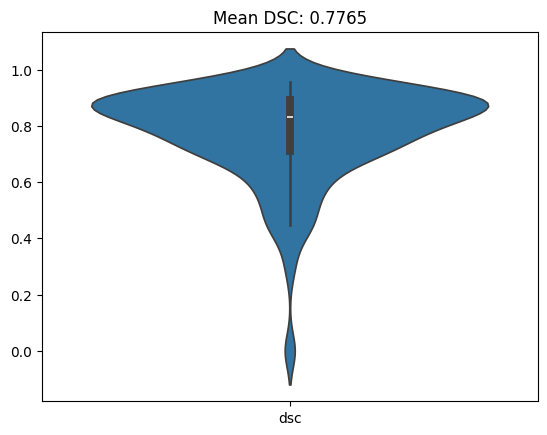

In [11]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame({"dsc": metrics[:,0].cpu()})

sns.violinplot(df, ).set_title(f"Mean DSC: {round(metrics.mean().item(), 4)}")